In [18]:
!pip install biopython

In [19]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import AlignIO
from Bio.motifs import Motif
from Bio.Align import AlignInfo
from Bio.SeqRecord import SeqRecord
import os
from Bio import motifs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, confusion_matrix, matthews_corrcoef,
    classification_report
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
from google.colab import drive

In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
print(os.path.exists('/content/drive/MyDrive/IT1244 Group Project/Project Code/Train_valid.fasta'))
y_train = [int(record.description.split('_')[-1]) for record in SeqIO.parse('/content/drive/MyDrive/IT1244 Group Project/Project Code/Train_valid.fasta','fasta')]
y_test = [int(record.description.split('_')[-1]) for record in SeqIO.parse('/content/drive/MyDrive/IT1244 Group Project/Project Code/test_cleaned.fasta','fasta')]

True


In [23]:
X_train = [str(record.seq) for record in SeqIO.parse('/content/drive/MyDrive/IT1244 Group Project/Project Code/Train_valid.fasta','fasta')]
X_test = [str(record.seq) for record in SeqIO.parse('/content/drive/MyDrive/IT1244 Group Project/Project Code/test_cleaned.fasta','fasta')]

##TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer for character-level features
tfidf_vectorizer = TfidfVectorizer(analyzer='char')

# Fit and transform the train sequences
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.fit_transform(X_test).toarray()

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

# Apply on a Classifier

In [25]:
from sklearn.preprocessing import StandardScaler

def standardize(data):
    data = pd.DataFrame(data)
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)
    standardized_df = pd.DataFrame(standardized_data, columns=data.columns)
    return standardized_df

In [26]:
# Function to evaluate model and print metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Confusion matrix and derived metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)

    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Accuracy: {accuracy}")
    print(f"MCC: {mcc}")
    print(f"AUC-ROC: {auc_roc}")

    # Manually plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return {"sensitivity": sensitivity, "specificity": specificity, "accuracy": accuracy, "mcc": mcc, "auc_roc": auc_roc}

In [27]:
# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

## Using TF-IDF as feature

In [28]:
from joblib import dump, load

def save_model(model, name):

    path = '/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/' + name + '_TF-IDF.joblib'

    # Saving the model
    dump(model, path)

    # Loading the model
    loaded_model = load(path)

Evaluating Logistic Regression
Sensitivity: 0.7293854748603352
Specificity: 0.631948312353793
Accuracy: 0.6643621766280107
MCC: 0.3405914194508748
AUC-ROC: 0.7503767978129086


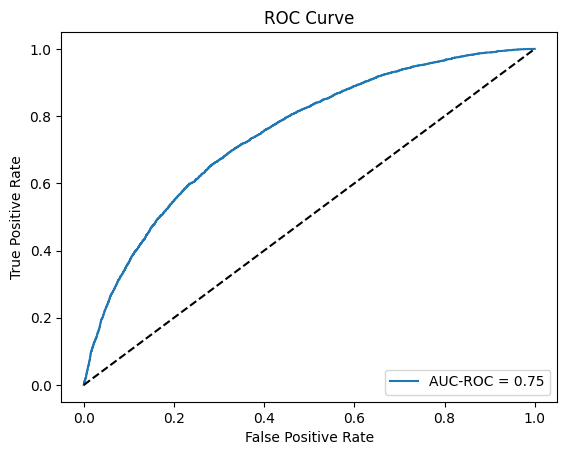

Evaluating Naive Bayes
Sensitivity: 0.6337430167597765
Specificity: 0.6183580260666147
Accuracy: 0.6234760630389533
MCC: 0.23813092433673697
AUC-ROC: 0.6808483256092696


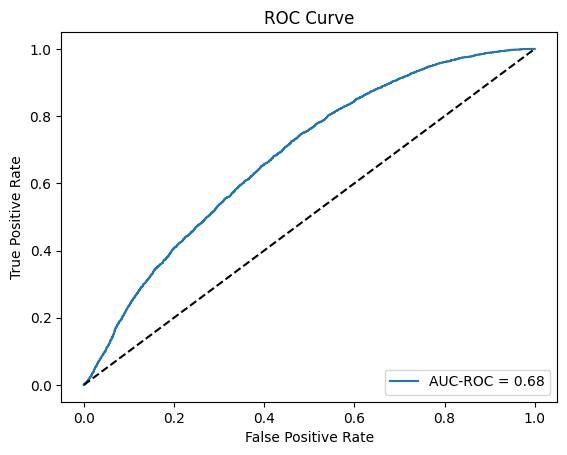

Evaluating Decision Tree
Sensitivity: 0.553072625698324
Specificity: 0.6822992090898964
Accuracy: 0.6393101397561701
MCC: 0.2267585086222241
AUC-ROC: 0.6176859173941103


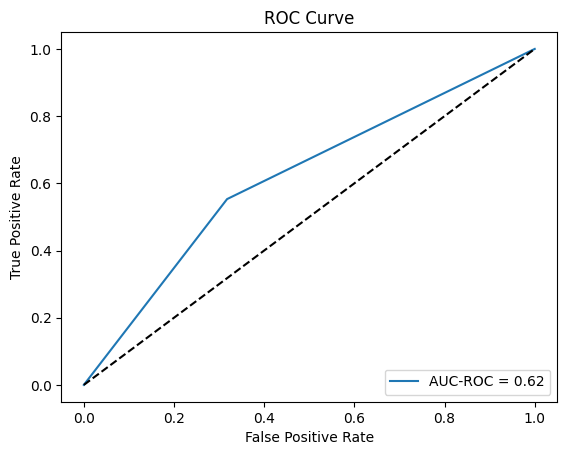

Evaluating Random Forest
Sensitivity: 0.576536312849162
Specificity: 0.8012699119973266
Accuracy: 0.7265090692833779
MCC: 0.38023729477974966
AUC-ROC: 0.7701668634244061


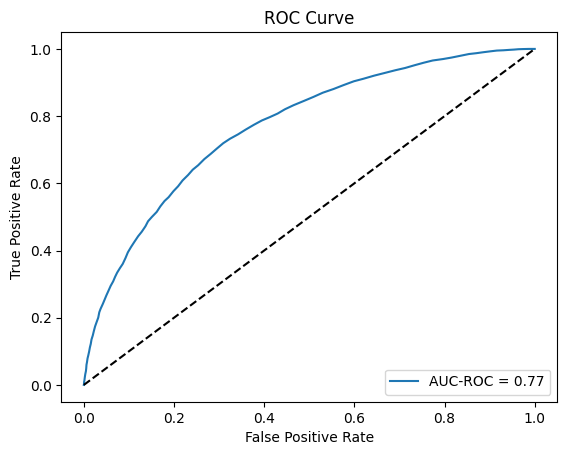

In [29]:
# Train and evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}")
    model.fit(X_train_tfidf, y_train)
    save_model(model, model_name)
    metrics = evaluate_model(model, X_test_tfidf, y_test)

In [30]:
 SVM = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
 SVM.fit(X_train_tfidf, y_train)
 evaluate_model(SVM, X_test_tfidf, y_test)

Sensitivity: 0.914413407821229
Specificity: 0.3681630834354461
Accuracy: 0.54988105857865
MCC: 0.29846184481123156
AUC-ROC: 0.7628174920015958


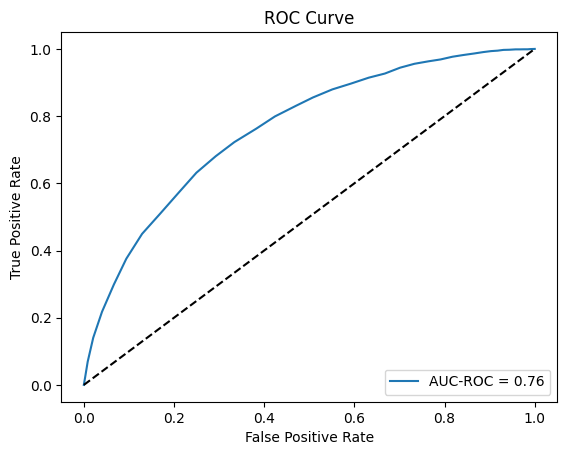

In [31]:
train_x_scaled = standardize(X_train_tfidf)
test_x_scaled = standardize(X_test_tfidf)

# mcc_list = []

# for k in range(1, 231, 2):
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn_pred = knn.fit(train_x_scaled, y_train)
#     knn_pred = knn.predict(test_x_scaled)
#     mcc_list.append([k, matthews_corrcoef(y_test, knn_pred)])

# print(max(mcc_list, key=lambda x: x[1]))

k = 37
model = KNeighborsClassifier(n_neighbors=k)
model.fit(train_x_scaled, y_train)
metrics = evaluate_model(model, test_x_scaled, y_test)